<i>Copyright (c) Microsoft Corporation. All rights reserved.</i>

<i>Licensed under the MIT License.</i>

# Accuracy on SOTA datasets 

We showed in the [01_training_and_evaluation_introduction](01_training_and_evaluation_introduction.ipynb) notebook how to train a DNN and use its feature embedding for image retrieval. In that notebook, the DNN was trained using a standard image classification loss.

More accurate similarity measures are typically based on DNNs which are trained explicitly for image similarity using Triplet Learning such as the [FaceNet](https://arxiv.org/pdf/1503.03832.pdf) paper. While these approaches achieve good accuracy, they are conceptually complex, slower, and more difficult to train/converge due to issue such as how to mine relevant triplets.

A recent paper from BMVC 2019 titled "[Classification is a Strong Baseline for Deep Metric Learning](https://arxiv.org/abs/1811.12649)" argues that this extra overhead is not necessary. Indeed, by making small changes to standard classification DNNs, the authors achieve results which are comparable or better than the state-of-the-art on three common datasets (CARS196, CUB200-2011, SOP).

This notebook aims to implements the paper, and reproduces reported results. 


### Datasets

Three of the most popular research datasets were used to evaluate this notebook, namely CARS-196, CUB-200-2011, and SOP.

| Name | #classes  | #images |
| ---- | --------- | ------- |
| CARS-196 | 196   | ~16,000 | 
| CUB-200-2011 |200| ~12,000 |
| SOP  |22634      | ~120,000|


We follow the literature closely to replicate the same train/test splits and the same evaluation protocal as most publications (see eg this [paper](https://arxiv.org/abs/1511.06452)). For the datasets above this means that out of the total N classes, all images within the first N/2 classes are used for training the DNN, and the remaining images are used for evaluating the image retrieval. Note that all images for a class are either fully assigned to training or to testing.


### Results

Using our (partial) implementation of the [BMVC 2019 paper](https://arxiv.org/abs/1811.12649) in this notebook, we achieve significant improvements compared to using the standard image classification loss in the [01_training_and_evaluation_introduction](01_training_and_evaluation_introduction.ipynb) notebook. This can be seen in the table below using the Recall@1 measure. Furthermore, we noticed that model convergence and over-fitting is much less of an issue with this notebook.

We aim to use similar parameters as reported in the paper to allow for a fair comparison. That is, we also use a ResNet-50 architecture, with 224 pixel input resolution, and a 512-dimensional embedding. We use a learning rate of 0.01 for the head, and 0.0001 for the body, using 12 epochs each. Note that good results are often achieved after just 6 epochs. Similar to the paper, we reduce the learning rates by a factor of 10 for the CUB-200-2011 dataset to achieve better accuracies. All training uses fastai's fit_one_cycle policy.

Recall@1 accuracies for the datasets with 512 dimensional features:

|               | CARS-196 | CUB-200-2011 | SOP |
| ------------- | -------- | ------------ | --- |
| 01 notebook   |    75%   |     53%      | 57% |
| This notebook |    78% LOW   |     58%      | 80% |
| Reported in paper| 84%   |     61%      | 78% | 


Recall@1 accuracies for the datasets with 512 dimensional features (USES ALL OF THE ORIGINAL MODEL):

|               | CARS-196 | CUB-200-2011 | SOP |
| ------------- | -------- | ------------ | --- |
| This notebook |    81%   |     60%      | 77% |


Recall@1 accuracies for the datasets with 2048 dimensional features:

|               | CARS-196 | CUB-200-2011 | SOP |
| ------------- | -------- | ------------ | --- |
| This notebook |    84% LOW  |     65%      | 81% |
| Reported in paper| 89%   |     65%      | 80% | 

Recall@1 accuracies for the datasets with 4096 dimensional features (USES PARTS OF ORIGINAL MODEL):

|               | CARS-196 | CUB-200-2011 | SOP |
| ------------- | -------- | ------------ | --- |
| This notebook |    87%   |     67%      | 81% |



Note the big gain in improvement compared to DNN training using standard classification loss (first row) versus using the suggested NormSoftmax loss (second row). For the CARS-196 and CUB-200-2011 datasets, our Recall@1 numbers are very close to the numbers reported in the [BMVC 2019 paper](https://arxiv.org/abs/1811.12649).

## Initialization

In [1]:
# Ensure edits to libraries are loaded and plotting is shown in the notebook.
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
# Regular python libraries
import math, os, random, sys, torch
import numpy as np
from pathlib import Path
import scrapbook as sb
import torch.nn as nn
from IPython.core.debugger import set_trace

# Fast.ai
import fastai
from fastai.layers import FlattenedLoss
from fastai.vision import (
    cnn_learner,
    DatasetType,
    ImageList,
    imagenet_stats,
    models,
)

# Computer Vision repository
sys.path.extend([".", "../.."])  # to access the utils_cv library
from utils_cv.classification.data import Urls  #<------------------- IMPORT SIMILARITY INSTEAD
from utils_cv.common.data import unzip_url
from utils_cv.common.gpu import which_processor, db_num_workers
from utils_cv.similarity.metrics import compute_distances
from utils_cv.similarity.model import compute_features, compute_features_learner
from utils_cv.similarity.plot import plot_distances

In [3]:
print(f"Fast.ai version = {fastai.__version__}")
which_processor()

Fast.ai version = 1.0.57
Torch is using GPU: Tesla V100-PCIE-16GB


## Data & Parameters

A small dataset is provided below to illustrate how to run this notebook. For our experiments, we used mainly the three research datasets mentioned above.

In [4]:
# Set dataset, model and evaluation parameters
DATA_FINETUNE_PATH = "/home/pabuehle/Desktop/data/cub_200_2011/train"
DATA_RANKING_PATH = "/home/pabuehle/Desktop/data/cub_200_2011/test"
#DATA_FINETUNE_PATH = "/home/pabuehle/Desktop/data/cars196/train"
#DATA_RANKING_PATH = "/home/pabuehle/Desktop/data/cars196/test"
#DATA_FINETUNE_PATH = "/home/pabuehle/Desktop/data/sop/train"
#DATA_RANKING_PATH = "/home/pabuehle/Desktop/data/sop/test"
#DATA_FINETUNE_PATH = "C:/Users/pabuehle/Desktop/data/cub_200_2011_subset3/train"
#DATA_RANKING_PATH = "C:/Users/pabuehle/Desktop/data/cub_200_2011_subset3/test"
#DATA_FINETUNE_PATH = "C:/Users/pabuehle/Desktop/data/cub_200_2011/train"
#DATA_RANKING_PATH = "C:/Users/pabuehle/Desktop/data/cub_200_2011/test"

#data_root_dir = unzip_url("https://cvbp.blob.core.windows.net/public/datasets/image_similarity/fridgeObjectsImageRetrieval.zip", exist_ok = True)
#data_root_dir = unzip_url("https://cvbp.blob.core.windows.net/public/datasets/image_similarity/fridgeObjectsImageRetrievalTiny.zip", exist_ok = True)
#DATA_FINETUNE_PATH = os.path.join(data_root_dir, "train")
#DATA_RANKING_PATH  = os.path.join(data_root_dir, "test")

# DNN configuration and learning parameters
EPOCHS_HEAD = 6 #12
EPOCHS_BODY = 1 #12
HEAD_LEARNING_RATE = 0.1 *   0.01   
BODY_LEARNING_RATE = 0.1 *   0.0001 
BATCH_SIZE = 32
IM_SIZE = 224
DROPOUT = 0 
ARCHITECTURE = models.resnet50

# Desired embedding dimension.
# Set to <=2048 to use the pooling layer suggested in paper. Set to 4096 to use original ResNet-50 pooling layer. 
EMBEDDING_DIM = 2048
assert EMBEDDING_DIM == 4096 or EMBEDDING_DIM <= 2048 

We can now build our training data object. use most images for training, and only a small percentage of the images for validation since we only need a rough estimate of the validation loss.

DATA FOR FINE-TUNING: 5689 training images and 175 validation images.


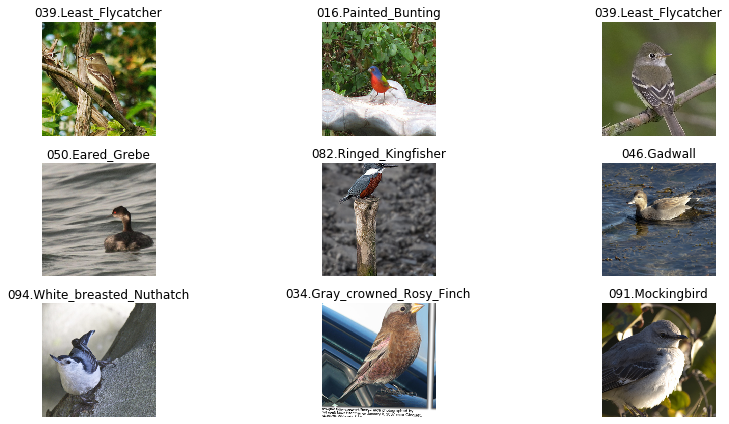

In [5]:
# Load images into fast.ai's ImageDataBunch object
random.seed(642)
data_finetune = (
    ImageList.from_folder(DATA_FINETUNE_PATH)
    .split_by_rand_pct(valid_pct=0.03, seed=20) # Keep a few validation images to estimate validation loss 
    .label_from_folder()
    .transform(tfms=fastai.vision.transform.get_transforms(), size=IM_SIZE)
    .databunch(bs=BATCH_SIZE, num_workers = db_num_workers())
    .normalize(imagenet_stats)
)

print(f"Data for fine-tuning: {len(data_finetune.train_ds.x)} training images and {len(data_finetune.valid_ds.x)} validation images.")

data_finetune.show_batch(rows=3, figsize=(12, 6))

## State-of-the-art layers and loss 

The cell below implements the loss and extra layers from the "[Classification is a Strong Baseline for Deep Metric Learning](https://arxiv.org/abs/1811.12649)" paper. Most of the code is copied from the [official repository](https://github.com/azgo14/classification_metric_learning) and slightly modified to work within the fast.ai framework. Note that we also extend the layers to optionally use the higher 4096 dimension which our ResNet-50 model outputs.

In [6]:
class L2NormalizedLinearLayer(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(L2NormalizedLinearLayer, self).__init__()
        self.weight = nn.Parameter(torch.Tensor(output_dim, input_dim))    
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        # Initialization from nn.Linear (https://github.com/pytorch/pytorch/blob/v1.0.0/torch/nn/modules/linear.py#L129)
        
    def forward(self, x):
        norm_weight = nn.functional.normalize(self.weight, dim=1)
        prediction_logits = nn.functional.linear(x, norm_weight)
        return prediction_logits
        
    
class EmbeddedFeatureWrapper(nn.Module):
    def __init__(self, input_dim, output_dim, dropout=0):
        super(EmbeddedFeatureWrapper, self).__init__()
        self.output_dim = output_dim
        self.dropout = dropout
        if output_dim != 4096:
            self.pool = nn.AdaptiveAvgPool2d(1)
        self.standardize = nn.LayerNorm(input_dim, elementwise_affine = False)
        self.remap = None
        if input_dim != output_dim:
           self.remap = nn.Linear(input_dim, output_dim, bias = False)
        if dropout > 0:
            self.dropout = nn.Dropout(dropout) 
    
    def forward(self, x):
        if self.output_dim != 4096:
            x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.standardize(x)
        if self.remap:
           x = self.remap(x)
        if self.dropout > 0:
            x = self.dropout(x)      
        x = nn.functional.normalize(x, dim=1)
        return x
    
    
class NormSoftmaxLoss(nn.Module):
    """
    L2 normalize weights and apply temperature scaling on logits.
    """
    def __init__(self, temperature=0.05):
        super(NormSoftmaxLoss, self).__init__() 
        self.temperature = temperature
        self.loss_fn = nn.CrossEntropyLoss()
 
    def forward(self, prediction_logits, instance_targets):
        loss = self.loss_fn(prediction_logits / self.temperature, instance_targets)
        return loss

## Modified classification DNN

We begin by retrieving a [ResNet18](https://arxiv.org/pdf/1512.03385.pdf) CNN from fast.ai's library which is pre-trained on ImageNet, and fine-tune the model on our training set. We use the same training parameters and take the same approach as what we did in our [classification notebooks](https://github.com/microsoft/ComputerVision/tree/master/classification/notebooks), training first the (new) last layer only, and then the full DNN.

Note how we train the DNN here on an image classification task but will use it as featurizer later for image similarity.

In [7]:
learn = cnn_learner(
    data_finetune,
    ARCHITECTURE,
    metrics=[],
    ps=DROPOUT 
)

print("** Original model **")
print(learn.model[1])

** Original model **
Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): Flatten()
  (2): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Linear(in_features=4096, out_features=512, bias=True)
  (4): ReLU(inplace=True)
  (5): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): Linear(in_features=512, out_features=100, bias=True)
)


Modify the original model to include the new layers

In [8]:
# By default uses 2048 dimensional pooling layer as implemented in paper.
# Optionally can instead keep the 4096-dimensional pooling layer from the ResNet-50 model.
if EMBEDDING_DIM != 4096:
    modules = []
    pooling_dim = 2048
else:
    modules = [l for l in learn.model[1][:3]]
    pooling_dim = 4096
    
# Add new layers
modules.append(EmbeddedFeatureWrapper(input_dim=pooling_dim, output_dim=EMBEDDING_DIM, dropout=DROPOUT))
modules.append(L2NormalizedLinearLayer(input_dim=EMBEDDING_DIM, output_dim=len(data_finetune.classes)))
learn.model[1] = nn.Sequential(*modules)

# Create new learner object since otherwise the new layers are not updated during backprop 
learn = fastai.vision.Learner(data_finetune, learn.model)

# Update loss function
learn.loss_func = FlattenedLoss(NormSoftmaxLoss)

print("\n** Edited model **")
print(learn.model[1])


** Edited model **
Sequential(
  (0): EmbeddedFeatureWrapper(
    (pool): AdaptiveAvgPool2d(output_size=1)
    (standardize): LayerNorm((2048,), eps=1e-05, elementwise_affine=False)
  )
  (1): L2NormalizedLinearLayer()
)


## Run DNN training

In [10]:
# Train the last layer using a larger rate since most of the DNN is fixed.
learn.fit_one_cycle(EPOCHS_HEAD, HEAD_LEARNING_RATE) 

epoch,train_loss,valid_loss,time
0,2.391967,1.273095,00:28
1,0.958711,0.818618,00:24
2,0.651273,0.666720,00:24
3,0.500394,0.612171,00:24
4,0.400899,0.566110,00:26
5,0.338856,0.568531,00:24


Let's now unfreeze all the layers and fine-tuning the model more


In [12]:
learn.unfreeze()


In [13]:
learn.fit_one_cycle(EPOCHS_BODY, BODY_LEARNING_RATE)

epoch,train_loss,valid_loss,time
0,0.347277,0.554158,00:28


## Feature extraction

We now load the ranking set and extract the DNN features for each image 

Data for retrieval evaluation: 5924 images.


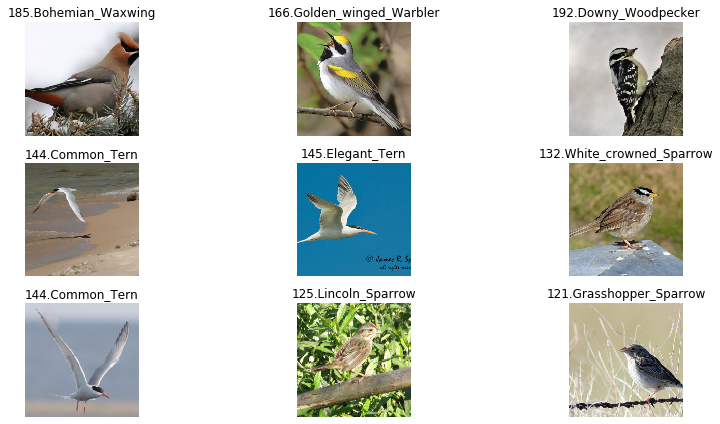

In [30]:
# Load images into fast.ai's ImageDataBunch object
data_rank = (
    ImageList.from_folder(DATA_RANKING_PATH)
    .split_none()
    .label_from_folder()
    .transform(size=IM_SIZE) 
    .databunch(bs=BATCH_SIZE, num_workers = db_num_workers())
    .normalize(imagenet_stats)
)

print(f"Data for retrieval evaluation: {len(data_rank.train_ds.x)} images.")

# Display example images
data_rank.show_batch(rows=3, figsize=(12, 6))

The following line will allow us to extract the DNN features after running an image  through the model.

In [15]:
#Compute DNN features for all validation images
embedding_layer = learn.model[1][-2]
dnn_features = compute_features_learner(data_rank, DatasetType.Train, learn, embedding_layer)

## Image Retrieval Example
The cell below shows how to find and display the most similar images in the validation set for a given query image (which we also select from the validation set). This example is similar to the one shown in the [00_webcam.ipynb](https://github.com/microsoft/ComputerVision/tree/master/similarity/notebooks/00_webcam.ipynb) notebook. 

Query image path: /home/pabuehle/Desktop/data/cub_200_2011/test/106.Horned_Puffin/Horned_Puffin_0026_100937.jpg
Query feature dimension: 2048


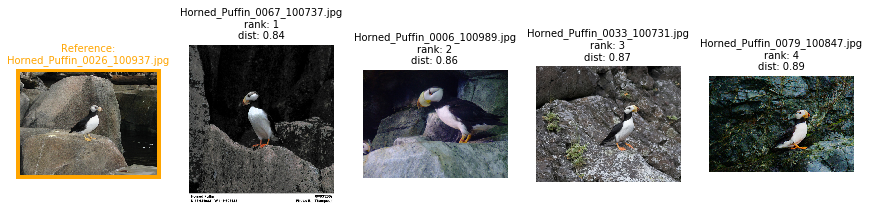

In [24]:
# Get the DNN feature for the query image
query_im_path =  str(data_rank.train_ds.items[1])
query_feature = dnn_features[query_im_path]
print(f"Query image path: {query_im_path}")
print(f"Query feature dimension: {len(query_feature)}")
assert len(query_feature) == EMBEDDING_DIM

# Compute the distances between the query and all reference images
distances = compute_distances(query_feature, dnn_features)
plot_distances(distances, num_rows=1, num_cols=5, figsize=(15,5))

## Quantitative evaluation

Our approach for quantitative evaluation is as follows:
- We extract the features of each query image in the query set, and search the K most similar images in the gallery set. 
- If one of the K retrieved images have the same label with the query image, then that increases recall.

In [17]:
#init
count = 0
labels = data_rank.train_ds.y
im_paths = data_rank.train_ds.items
assert len(labels) == len(im_paths) == len(dnn_features)

# As query images, and to speed up accuracy computation, only use a subset of at least 500 images.
step = math.ceil(len(im_paths)/500.0)
query_indices = range(len(im_paths))[::step]

# Loop over all images and use as query image once
for query_index in query_indices:
    if query_index % (step*100) == 0:
        print(query_index, len(im_paths))

    # Get query information
    query_im_path =  str(im_paths[query_index])
    query_feature = dnn_features[query_im_path]
    
    # Compute distance to all images in the gallery set. We use our L2-distance here which, 
    # since our features are L2-normalized, is equivalent (and faster) to using cosine distance.
    # (See: https://en.wikipedia.org/wiki/Cosine_similarity)
    distances = compute_distances(query_feature, dnn_features)

    # Find the smallest distance
    min_dist = float('inf')
    min_dist_index = None
    for index, distance in enumerate(distances):
        if index != query_index: #ignore the query image itself
            if distance[1] < min_dist:
                min_dist = distance[1]
                min_dist_index = index

    # Count how often the image with minimum distance has the same label as the query
    if labels[query_index] == labels[min_dist_index]:
        count += 1

0 5924
600 5924
1200 5924
1800 5924
2400 5924
3000 5924
3600 5924
4200 5924
4800 5924
5400 5924


In [18]:
recallAt1 = 100.0 * count / len(query_indices)
print("Recall@1 accuracy = {:2.2f}".format(recallAt1))

Recall@1 accuracy = 63.46


In [19]:
# Log some outputs using scrapbook which are used during testing to verify correct notebook execution
sb.glue("recallAt1", recallAt1)